In [20]:
import pandas as pd
import numpy as np
import yfinance as yf
import seaborn as sns
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage, risk_matrix
from pypfopt import CovarianceShrinkage
from pypfopt import EfficientFrontier, expected_returns
from pypfopt.expected_returns import mean_historical_return

In [2]:
ibex35 = pd.read_csv("IBEX_data.csv")

tickers = [
    "ACS.MC", "ACX.MC", "AMS.MC", "BBVA.MC", "BKT.MC", "VIS.MC", "CABK.MC", "NTGY.MC", 
    "ELE.MC", "ENG.MC", "FER.MC", "GRF.MC", "IAG.MC", "IBE.MC", "TRE.MC", "IDR.MC", "ITX.MC", 
    "MAP.MC", "MEL.MC", "MTS.MC", "RED.MC", "REP.MC", "SAB.MC", "SAN.MC", "TEF.MC"
]

ibex35 = ibex35[ibex35['Ticker'].isin(tickers)].copy()
ibex35['Date'] = pd.to_datetime(ibex35['Date'])

## Convert to Weekly Data

In [3]:
dfs = {}

for ticker in tickers:
    dfs[ticker] = ibex35[ibex35['Ticker'] == ticker].copy()


for ticker, df in dfs.items():
    
    #Daily percentage change 
    df.loc[:, 'Return'] = df['Adj Close'].pct_change()
    
    dfs[ticker] = df.iloc[1:].reset_index(drop=True)

    dfs[ticker] = df.drop(columns=['Open', 'High', 'Low', 'Close', 'Volume'])
    

def convert_to_weekly(df):
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    
    # Resample and get the last 'Adj Close' for the week
    weekly_df = df.resample('W-FRI').agg({'Adj Close': 'last'}).dropna().reset_index()
    
    #Compounded return for the week
    df['Return'] = df['Return'] + 1
    weekly_returns = df['Return'].resample('W-FRI').prod() - 1
    weekly_df['Return'] = weekly_returns.reset_index(drop=True)
    
    return weekly_df

#Apply the function to each DataFrame in the dictionary
for ticker, df in dfs.items():
    dfs[ticker] = convert_to_weekly(df)
    

# Function to add continuous 'Week' column and 'Year' column
def add_week_year_columns(df, start_date):
    df['Year'] = df['Date'].dt.year
    df['Week'] = ((df['Date'] - pd.to_datetime(start_date)).dt.days // 7) + 1
    return df

# Get the earliest date in the dataset to start the week count
earliest_date = min(df['Date'].min() for df in dfs.values())


for ticker, df in dfs.items():
    dfs[ticker] = add_week_year_columns(df, earliest_date)

    dfs[ticker]['Ticker'] = ticker
    

ibex35 = pd.concat(dfs.values(), ignore_index=True)

In [4]:
ibex35.head(2)

,Date,Adj Close,Return,Year,Week,Ticker
0,2013-01-04,10.382668,0.036765,2013,1,ACS.MC
1,2013-01-11,10.287994,-0.009118,2013,2,ACS.MC


In [5]:
returns = ibex35.pivot_table(values='Return', index='Week', columns='Ticker')
closing = ibex35.pivot_table(values='Adj Close', index='Week', columns='Ticker')

## Functions

In [6]:
# First the sample covariance matrix
def sample_cov (closing):
    
    sample_cov = risk_matrix(closing, method='sample_cov')

    return sample_cov


# shrinkage method #1 - constant variance
def constant_variance (closing):
    
    mu = mean_historical_return(closing)
    constant_variance = CovarianceShrinkage(closing).ledoit_wolf()

    return constant_variance


# shrinkage method #2 - single factor
def single_factor (closing):
    
    mu = mean_historical_return(closing)
    single_factor = CovarianceShrinkage(closing).ledoit_wolf(shrinkage_target='single_factor')

    return single_factor


# shrinkage method #3 - constant correlation
def constant_correlation (closing):
    
    mu = mean_historical_return(closing)
    constant_correlation = CovarianceShrinkage(closing).ledoit_wolf(shrinkage_target='constant_correlation')

    return constant_correlation



# shrinkage method #4 - oracle approximating
def oracle_approximation (closing):
    
    oracle_approximation = risk_matrix(closing, method='oracle_approximating')
    
    return oracle_approximation



# shrinkage method #5 - uses indetity matrix with a fixed delta of 20%
def shrunk_covariance(closing):
    
    shrunk_covariance_matrix = CovarianceShrinkage(closing).shrunk_covariance(delta=0.2)
    
    return shrunk_covariance_matrix

## Optimization

In [7]:
def get_optimal_weights(closing_prices, covariance_matrix):
    """
    Calculate the optimal weights for a portfolio using the Efficient Frontier and the maximum Sharpe ratio.
    
    Parameters:
    closing_prices (pd.DataFrame): DataFrame containing the closing prices of the assets.
    
    Returns:
    dict: Optimal weights for the portfolio.
    """
    
    # Calculate the expected returns and the sample covariance matrix
    mu = expected_returns.mean_historical_return(closing_prices)
    S = covariance_matrix

    # Initialize the Efficient Frontier object
    ef = EfficientFrontier(mu, S)

    # Optimize for the maximum Sharpe ratio
    weights = ef.max_sharpe()
    
    # Clean the weights to get rid of tiny allocations
    cleaned_weights = ef.clean_weights()
    
    return cleaned_weights

## Returns Function

In [8]:
def calculate_portfolio_return(weights, returns):
    """
    Calculate the portfolio return based on the given weights and returns.
    
    Parameters:
    weights (dict): Dictionary of asset weights.
    returns (pd.Series): Series of asset returns.
    
    Returns:
    float: Portfolio return.
    """
    portfolio_return = sum(weights[ticker] * returns[ticker] for ticker in weights.keys())
    return portfolio_return

## Backtesting

In [9]:
import warnings
import time
warnings.filterwarnings('ignore')

# (260 weeks for 5 years)
window_size = 260

portfolio_returns = []

start_time = time.time()

covariance_functions = {
    'sample_cov': sample_cov,
    'constant_variance': constant_variance,
    'single_factor': single_factor,
    'constant_correlation': constant_correlation,
    'oracle_approximation': oracle_approximation,
    'shrunk_covariance': shrunk_covariance
}

for start_week in range(0, len(closing) - window_size - 1):  # Adjusted to avoid index out of range
    end_week = start_week + window_size
    
    # Get the training data for the current window
    training_data = closing.iloc[start_week:end_week]
    
    # Calculate the covariance matrices
    covariance_matrices = {name: func(training_data) for name, func in covariance_functions.items()}
    
    # Get the returns for the next week (testing point)
    next_week = returns.iloc[end_week]
    
    for name, cov_matrix in covariance_matrices.items():
        # Get the optimal weights using the Efficient Frontier
        optimal_weights = get_optimal_weights(training_data, cov_matrix)
        
        # Calculate the portfolio return for the next week
        next_week_return = calculate_portfolio_return(optimal_weights, next_week)
        
        # Store the return in the list
        portfolio_returns.append({
            'week': end_week + 1,  # Adjusted to show the testing week
            'method': name,
            'return': next_week_return
        })

end_time = time.time()
total_time = end_time - start_time

portfolio_returns_df = pd.DataFrame(portfolio_returns)

print(portfolio_returns_df)
print(f"Total backtesting time: {total_time} seconds")

portfolio_returns_df['Year'] = (portfolio_returns_df['week'] // 52) + 1
portfolio_returns_df = portfolio_returns_df[portfolio_returns_df['Year'] != 12]
portfolio_returns_df.tail()

      week                method    return
0      261            sample_cov -0.008818
1      261     constant_variance -0.008889
2      261         single_factor -0.008672
3      261  constant_correlation -0.008474
4      261  oracle_approximation -0.008869
...    ...                   ...       ...
1873   573     constant_variance  0.001291
1874   573         single_factor  0.001852
1875   573  constant_correlation  0.002676
1876   573  oracle_approximation  0.001805
1877   573     shrunk_covariance  0.001061

[1878 rows x 3 columns]
Total backtesting time: 44.65874791145325 seconds


,week,method,return,Year
1861,571,constant_variance,0.020954,11
1862,571,single_factor,0.022227,11
1863,571,constant_correlation,0.023332,11
1864,571,oracle_approximation,0.021728,11
1865,571,shrunk_covariance,0.019007,11


In [10]:
methods = ['sample_cov', 'constant_correlation', 'shrunk_covariance', 'constant_variance', 'single_factor', 'oracle_approximation']

for method in methods:
    filtered_df = portfolio_returns_df[portfolio_returns_df['method'] == method]
    sumo = filtered_df['return'].sum()
    print(f"Total Return for {method.replace('_', ' ').title()}: {sumo:.4%}")

Total Return for Sample Cov: 37.3094%
Total Return for Constant Correlation: 42.0311%
Total Return for Shrunk Covariance: 36.0245%
Total Return for Constant Variance: 37.3552%
Total Return for Single Factor: 38.4507%
Total Return for Oracle Approximation: 37.3132%


## Annual Performance

Calculate Annual Returns from Weekly Returns

In [11]:
def calculate_annual_return(weekly_returns):
    """
    Calculate the annual return given weekly returns.
    
    Parameters:
    weekly_returns (pd.Series): Series of weekly returns.
    
    Returns:
    float: Annual return.
    """
    compounded_growth = np.prod(1 + weekly_returns) - 1
    return compounded_growth

# Group the returns by method and year, then calculate annual returns
grouped_returns = portfolio_returns_df.groupby(['method', 'Year'])['return']
annual_returns = grouped_returns.apply(calculate_annual_return)

# Convert the results to a DataFrame
annual_returns_df = annual_returns.reset_index()
annual_returns_df.columns = ['Method', 'Year', 'Annual Return']

# Display the results
annual_returns_df.head(2)

,Method,Year,Annual Return
0,constant_correlation,6,0.044005
1,constant_correlation,7,0.167884


In [12]:
# Calculate the standard deviation of weekly returns for each method and year
annual_std_dev = portfolio_returns_df.groupby(['method', 'Year'])['return'].std().reset_index()

# Rename the column for clarity
annual_std_dev.rename(columns={'return': 'Annual Std Dev'}, inplace=True)

# Standardizing column names
annual_std_dev.rename(columns={'method': 'Method'}, inplace=True)

# Now merge the DataFrames
annual_data = pd.merge(annual_returns_df, annual_std_dev, on=['Method', 'Year'])
annual_data.head(10)

,Method,Year,Annual Return,Annual Std Dev
0,constant_correlation,6,0.044005,0.025076
1,constant_correlation,7,0.167884,0.019245
2,constant_correlation,8,0.001504,0.040839
3,constant_correlation,9,-0.089657,0.029741
4,constant_correlation,10,0.070941,0.035347
5,constant_correlation,11,0.115539,0.021091
6,constant_variance,6,0.045036,0.024614
7,constant_variance,7,0.164009,0.019101
8,constant_variance,8,-0.004545,0.040219
9,constant_variance,9,-0.092227,0.027648


## Sharpe Ratio 

Sharpe Ratio = $(\frac{R_p - R_f}{\sigma_p})$

Where:
- $(R_p)$ = Average return of the portfolio for the evaluated period.
- $(R_f)$ = Risk-free rate (could be a constant or vary over time)
- $(\sigma_p)$ = Standard deviation of the portfolio’s returns.

In [13]:
# Define the risk-free rate
risk_free_rate = 0.02

# Calculate the Sharpe Ratio
annual_data['Sharpe Ratio'] = (annual_data['Annual Return'] - risk_free_rate) / annual_data['Annual Std Dev']

annual_data.head(10)

,Method,Year,Annual Return,Annual Std Dev,Sharpe Ratio
0,constant_correlation,6,0.044005,0.025076,0.957319
1,constant_correlation,7,0.167884,0.019245,7.684109
2,constant_correlation,8,0.001504,0.040839,-0.452902
3,constant_correlation,9,-0.089657,0.029741,-3.687106
4,constant_correlation,10,0.070941,0.035347,1.441174
5,constant_correlation,11,0.115539,0.021091,4.529760
6,constant_variance,6,0.045036,0.024614,1.017119
7,constant_variance,7,0.164009,0.019101,7.539361
8,constant_variance,8,-0.004545,0.040219,-0.610290
9,constant_variance,9,-0.092227,0.027648,-4.059089


In [14]:
# Group by 'Method' and calculate the mean Sharpe Ratio for each method
mean_sharpe_ratios = annual_data.groupby('Method')['Sharpe Ratio'].mean().reset_index()

# Rename columns for clarity
mean_sharpe_ratios.rename(columns={'Sharpe Ratio': 'Mean Sharpe Ratio'}, inplace=True)

# Display the results
print(mean_sharpe_ratios)

                 Method  Mean Sharpe Ratio
0  constant_correlation           1.745392
1     constant_variance           1.513661
2  oracle_approximation           1.469975
3            sample_cov           1.431333
4     shrunk_covariance           1.729514
5         single_factor           1.518291


## Visualization Returns

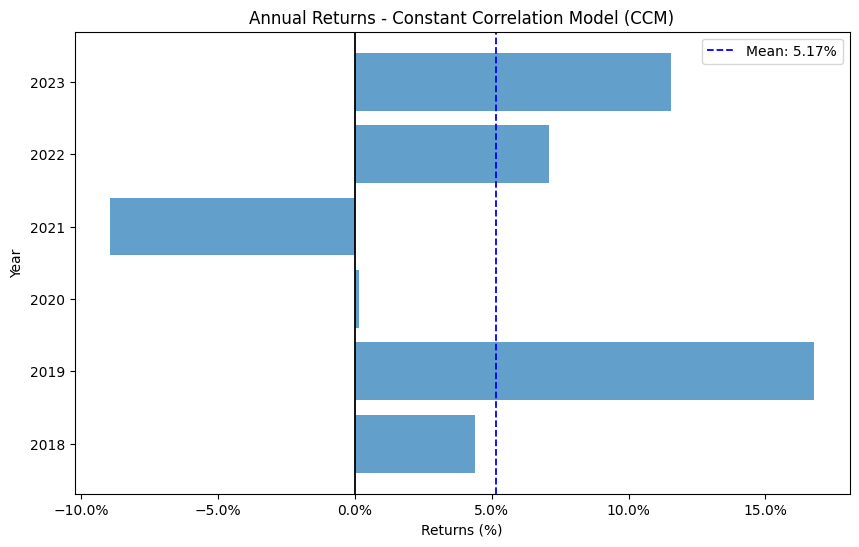

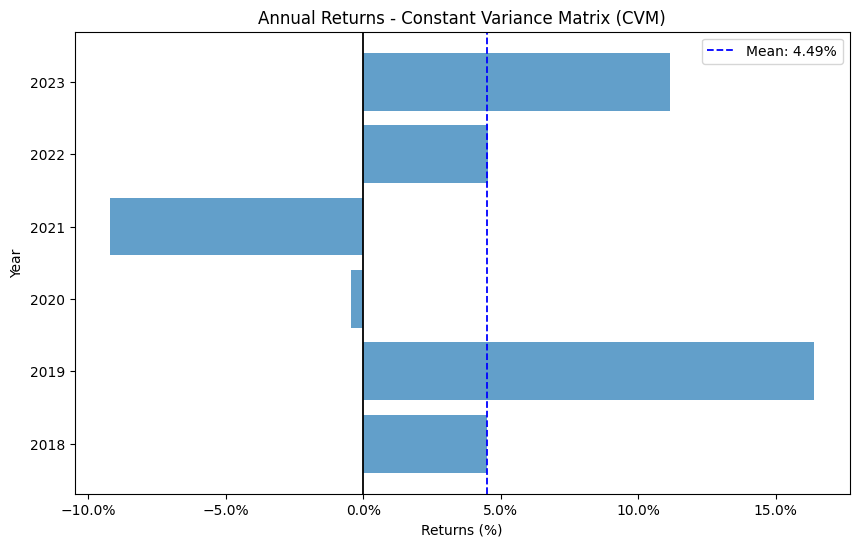

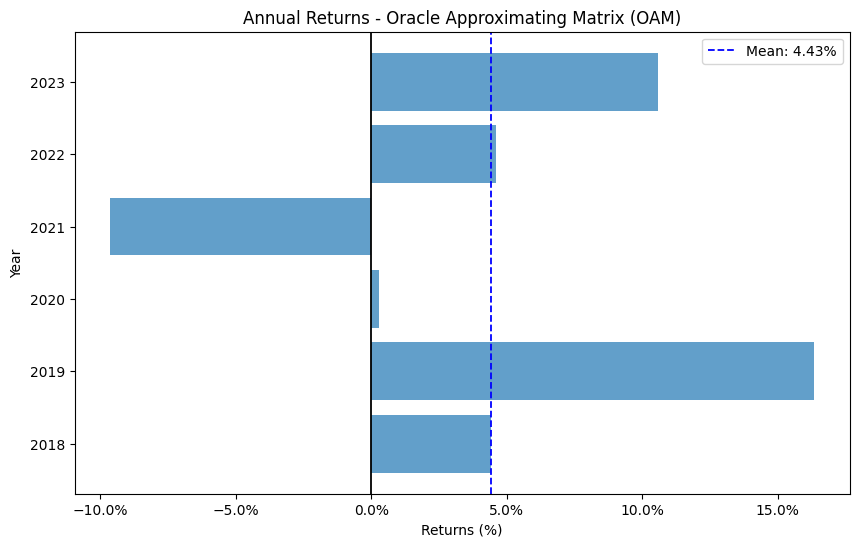

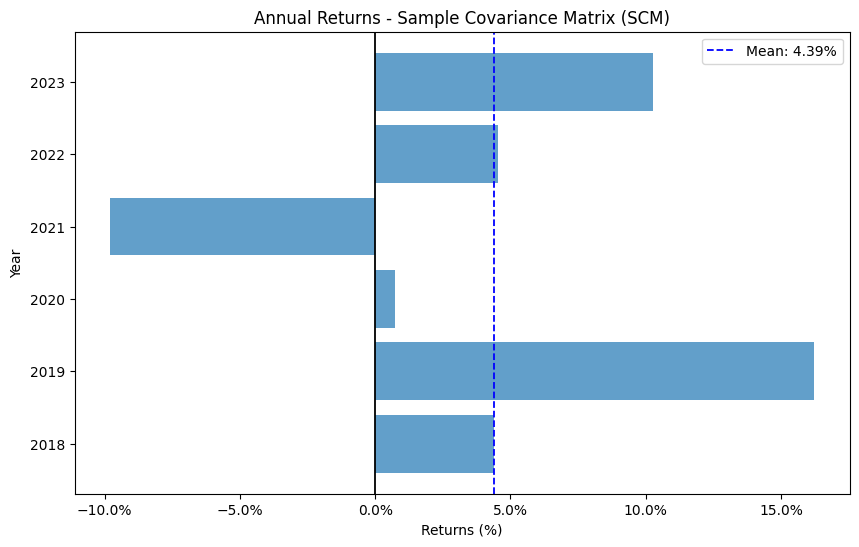

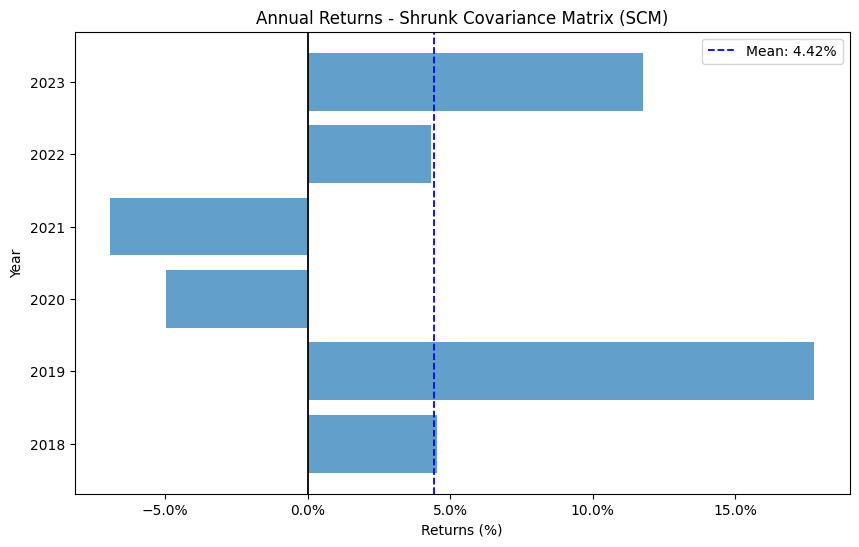

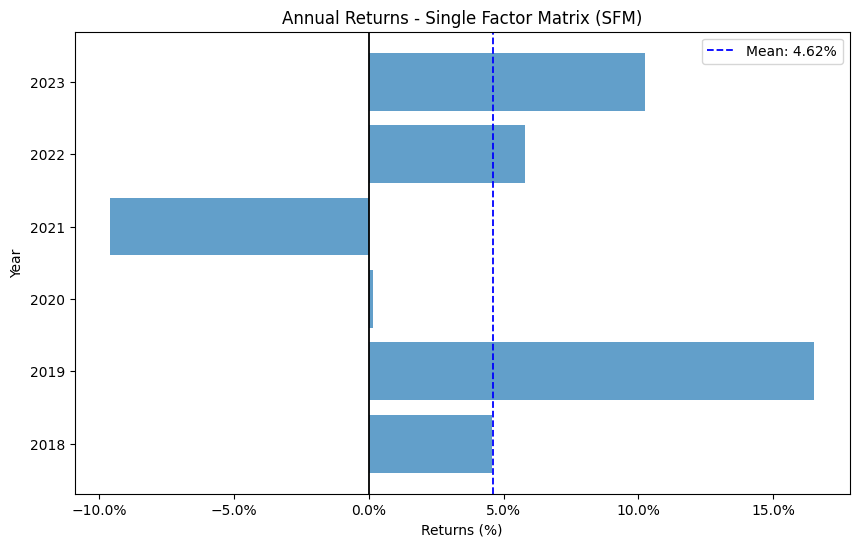

In [15]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

method_descriptions = {
    'sample_cov': 'Sample Covariance Matrix (SCM)',
    'constant_variance': 'Constant Variance Matrix (CVM)',
    'single_factor': 'Single Factor Matrix (SFM)',
    'constant_correlation': 'Constant Correlation Model (CCM)',
    'oracle_approximation': 'Oracle Approximating Matrix (OAM)',
    'shrunk_covariance': 'Shrunk Covariance Matrix (SCM)'
}

# Mapping of year labels (year 6 corresponds to 2018)
year_mapping = {
    6: 2018,
    7: 2019,
    8: 2020,
    9: 2021,
    10: 2022,
    11: 2023
}


methods = annual_returns_df['Method'].unique()

for method in methods:
    method_data = annual_returns_df[annual_returns_df['Method'] == method]
    mean_return = method_data['Annual Return'].mean()
    
    plt.figure(figsize=(10, 6))
    plt.barh(method_data['Year'].map(year_mapping), method_data['Annual Return'], align='center', alpha=0.7)
    
    plt.axvline(0, color='black', linewidth=1.3)  
    plt.axvline(mean_return, color='blue', linestyle='--', linewidth=1.3, label=f'Mean: {mean_return:.2%}')  
    
    plt.xlabel('Returns (%)')
    plt.ylabel('Year')
    plt.title(f'Annual Returns - {method_descriptions[method]}')
    plt.legend()
    
    # Format x-axis to show percentages
    plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    
    # Display the plot
    plt.show()

## Visualization Sharpe Ratio

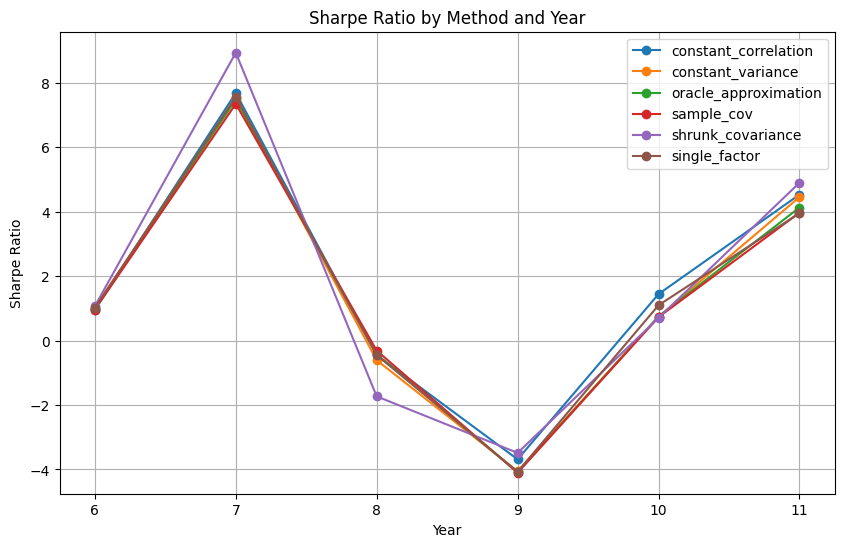

In [16]:
import matplotlib.pyplot as plt

# Plotting Sharpe Ratios for each method over the years
plt.figure(figsize=(10, 6))
for method in annual_data['Method'].unique():
    subset = annual_data[annual_data['Method'] == method]
    plt.plot(subset['Year'], subset['Sharpe Ratio'], marker='o', label=method)

plt.title('Sharpe Ratio by Method and Year')
plt.xlabel('Year')
plt.ylabel('Sharpe Ratio')
plt.legend()
plt.grid(True)
plt.show()

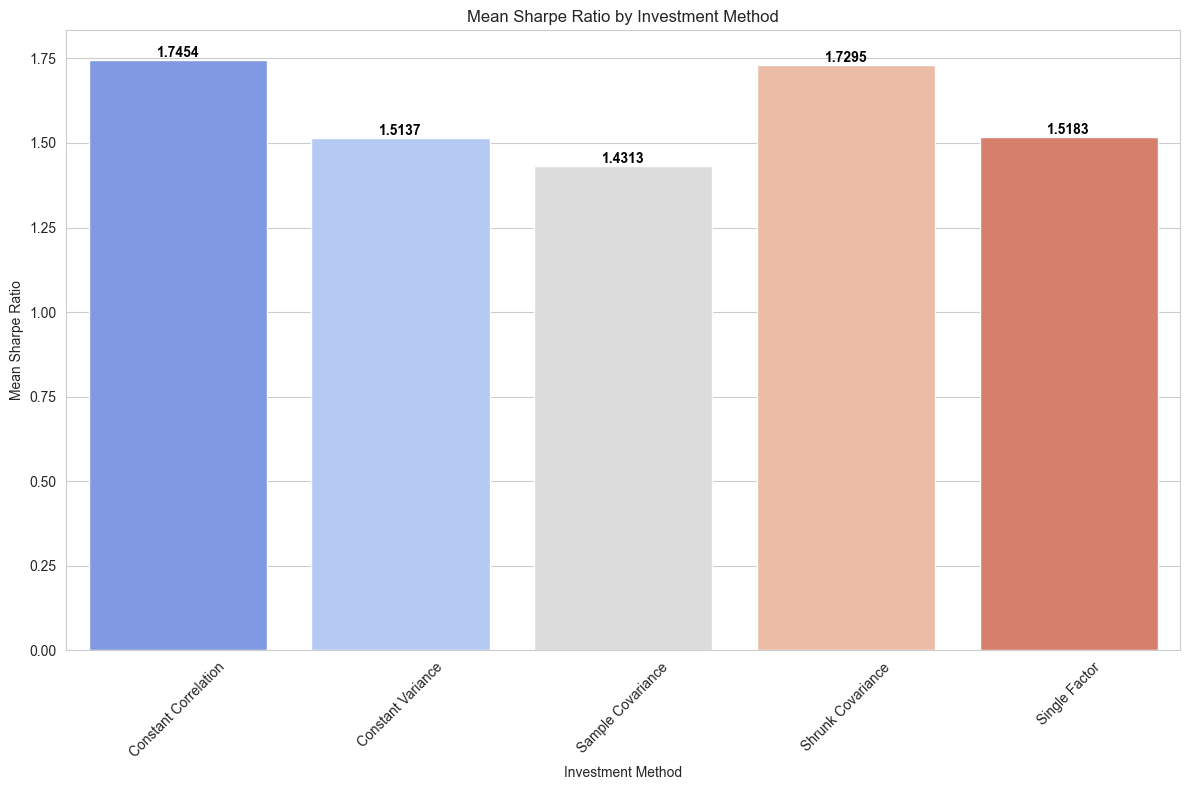

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define a mapping from your method variable names to descriptive names
method_names = {
    'constant_correlation': 'Constant Correlation',
    'constant_variance': 'Constant Variance',
    'single_factor': 'Single Factor',
    'oracle_approximating': 'Oracle Approximating',
    'sample_cov': 'Sample Covariance',
    'shrunk_covariance': 'Shrunk Covariance',
    'ledoit_wolf': 'Ledoit-Wolf Shrinkage',
    'constant_correlation_shrinkage': 'Constant Correlation Shrinkage',
}
# Update your DataFrame to replace the method identifiers with descriptive names
mean_sharpe_ratios['Method'] = mean_sharpe_ratios['Method'].map(method_names)

# Set the style of seaborn for more stylish plots
sns.set_style("whitegrid")

# Create a figure and axis object with matplotlib
plt.figure(figsize=(12, 8))
ax = plt.subplot(111)

# Create a bar chart using seaborn which automatically adds a grid
bars = sns.barplot(x='Method', y='Mean Sharpe Ratio', data=mean_sharpe_ratios, palette='coolwarm', ax=ax)

# Add labels and title
ax.set_xlabel('Investment Method')
ax.set_ylabel('Mean Sharpe Ratio')
ax.set_title('Mean Sharpe Ratio by Investment Method')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

# Add the actual value on top of each bar
for bar in bars.patches:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{bar.get_height():.4f}', 
            ha='center', va='bottom', fontweight='bold', color='black')

# Show the plot
plt.tight_layout()  # Adjust the layout to make room for the rotated x-axis labels
plt.show()

## New Graphs

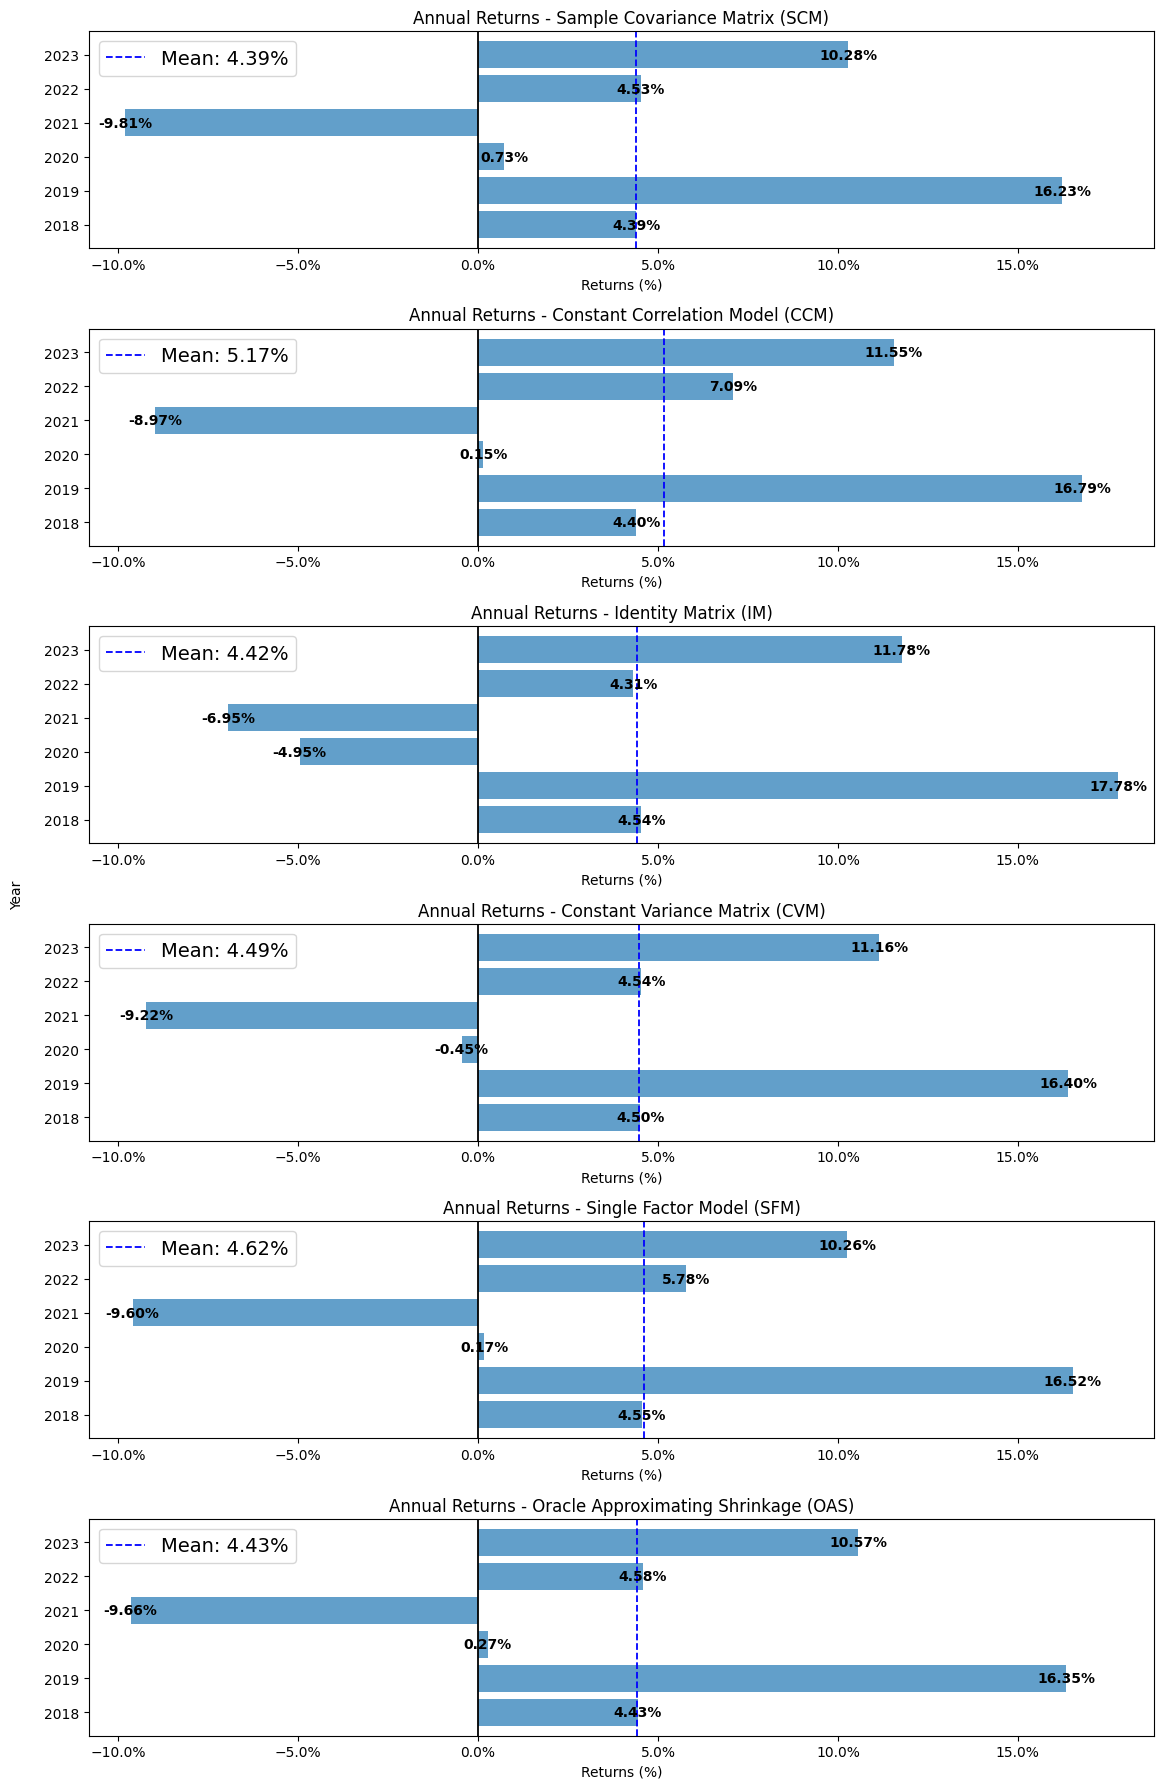

In [16]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# Ensure all plots have the same x-axis scale
max_return = (annual_returns_df['Annual Return'].max() + 0.01)
min_return = (annual_returns_df['Annual Return'].min() - 0.01)

# Specified order of methods
ordered_methods = ['sample_cov', 'constant_correlation', 'shrunk_covariance', 'constant_variance', 'single_factor', 'oracle_approximation']

fig, axes = plt.subplots(nrows=len(ordered_methods), ncols=1, figsize=(12, 18), sharey=True)

# Mapping of year labels (year 6 corresponds to 2018)
year_mapping = {
    6: 2018,
    7: 2019,
    8: 2020,
    9: 2021,
    10: 2022,
    11: 2023
}

# Method descriptions with updated "shrunk_covariance"
method_descriptions = {
    'sample_cov': 'Sample Covariance Matrix (SCM)',
    'constant_variance': 'Constant Variance Matrix (CVM)',
    'single_factor': 'Single Factor Model (SFM)',
    'constant_correlation': 'Constant Correlation Model (CCM)',
    'oracle_approximation': 'Oracle Approximating Shrinkage (OAS)',
    'shrunk_covariance': 'Identity Matrix (IM)'
}

for ax, method in zip(axes, ordered_methods):
    method_data = annual_returns_df[annual_returns_df['Method'] == method]
    method_data['Year'] = method_data['Year'].map(year_mapping)
    mean_return = method_data['Annual Return'].mean()

    bars = ax.barh(method_data['Year'], method_data['Annual Return'], align='center', alpha=0.7)
    ax.axvline(0, color='black', linewidth=1.3)  
    ax.axvline(mean_return, color='blue', linestyle='--', linewidth=1.3, label=f'Mean: {mean_return:.2%}')  
    ax.set_xlim(min_return, max_return)
    ax.set_xlabel('Returns (%)')
    ax.set_title(f'Annual Returns - {method_descriptions[method]}')
    ax.legend(fontsize=12)
    ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))

    # Add the actual value on top of each bar
    for bar in bars:
        width = bar.get_width()
        ax.text(width, bar.get_y() + bar.get_height()/2, f'{width:.2%}', 
                ha='center', va='center', fontweight='bold', color='black')

    # Increase the font size of the mean label
    ax.legend(loc='upper left', fontsize=14)

# Set a common y-label
fig.text(0.04, 0.5, 'Year', ha='center', va='center', rotation='vertical')

# Adjust layout to make room for the labels
plt.tight_layout(rect=[0.05, 0, 1, 1])
plt.show()

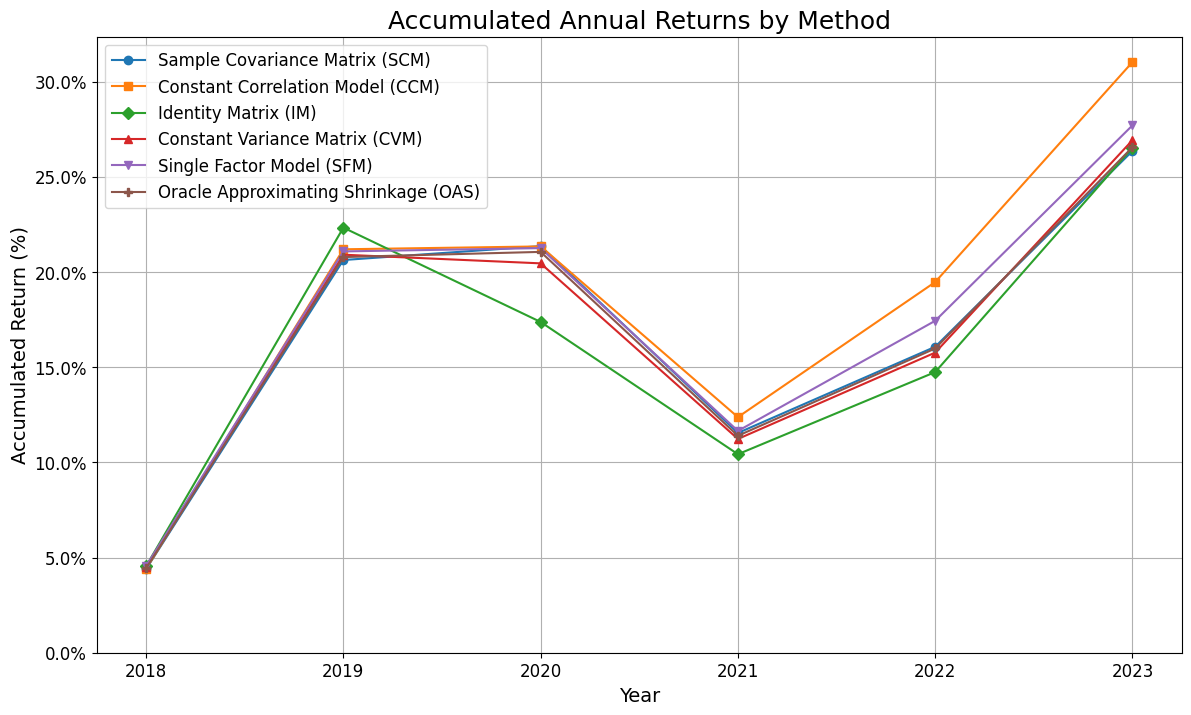

In [17]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# Calculate cumulative sum of annual returns for each method
annual_returns_df['Cumulative Return'] = annual_returns_df.groupby('Method')['Annual Return'].cumsum()

# Define different markers for each method
markers = ['o', 's', 'D', '^', 'v', 'P']

# Plot the cumulative returns
plt.figure(figsize=(14, 8))

for method, marker in zip(ordered_methods, markers):
    method_data = annual_returns_df[annual_returns_df['Method'] == method]
    plt.plot(method_data['Year'].map(year_mapping), method_data['Cumulative Return'], marker=marker, markersize=6, label=method_descriptions[method])

# Increase font sizes for title, labels, and legend
plt.title('Accumulated Annual Returns by Method', fontsize=18)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Accumulated Return (%)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

# Format y-axis to show percentages
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.ylim(0, None)  # Start y-axis at 0

# Increase the font size of the tick labels
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Display the plot
plt.show()


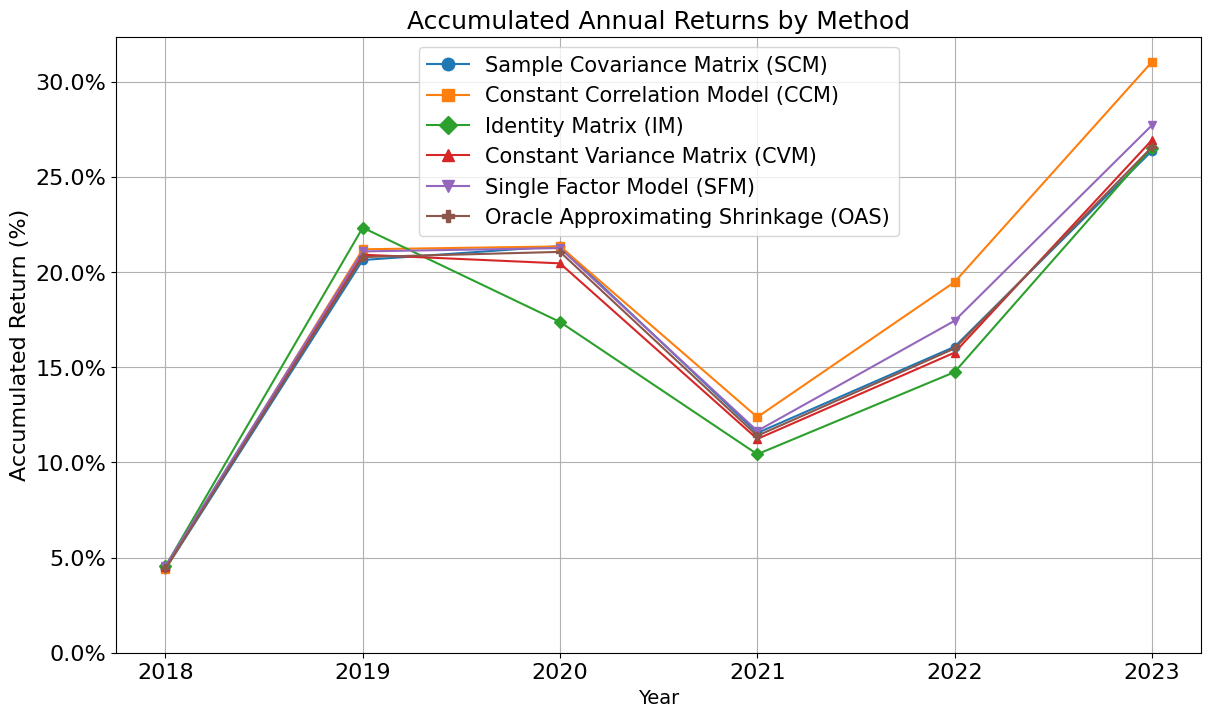

In [18]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# Calculate cumulative sum of annual returns for each method
annual_returns_df['Cumulative Return'] = annual_returns_df.groupby('Method')['Annual Return'].cumsum()

# Define different markers for each method
markers = ['o', 's', 'D', '^', 'v', 'P']

# Plot the cumulative returns
plt.figure(figsize=(14, 8))

for method, marker in zip(ordered_methods, markers):
    method_data = annual_returns_df[annual_returns_df['Method'] == method]
    plt.plot(method_data['Year'].map(year_mapping), method_data['Cumulative Return'], marker=marker, markersize=6, label=method_descriptions[method])

# Increase font sizes for title, labels, and legend
plt.title('Accumulated Annual Returns by Method', fontsize=18)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Accumulated Return (%)', fontsize=16)
plt.legend(fontsize=15, markerscale=1.5)  # Increased markerscale
plt.grid(True)

# Format y-axis to show percentages
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.ylim(0, None)  # Start y-axis at 0

# Increase the font size of the tick labels
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Display the plot
plt.show()

In [ ]:
# Calculate the annualized volatility
#annual_data['Annualized Volatility'] = annual_data.groupby('Method')['Annual Std Dev'].transform(lambda x: x * np.sqrt(52))

# Calculate the average annualized volatility for each method
#avg_volatility_df = annual_data.groupby('Method')['Annualized Volatility'].mean().reset_index()

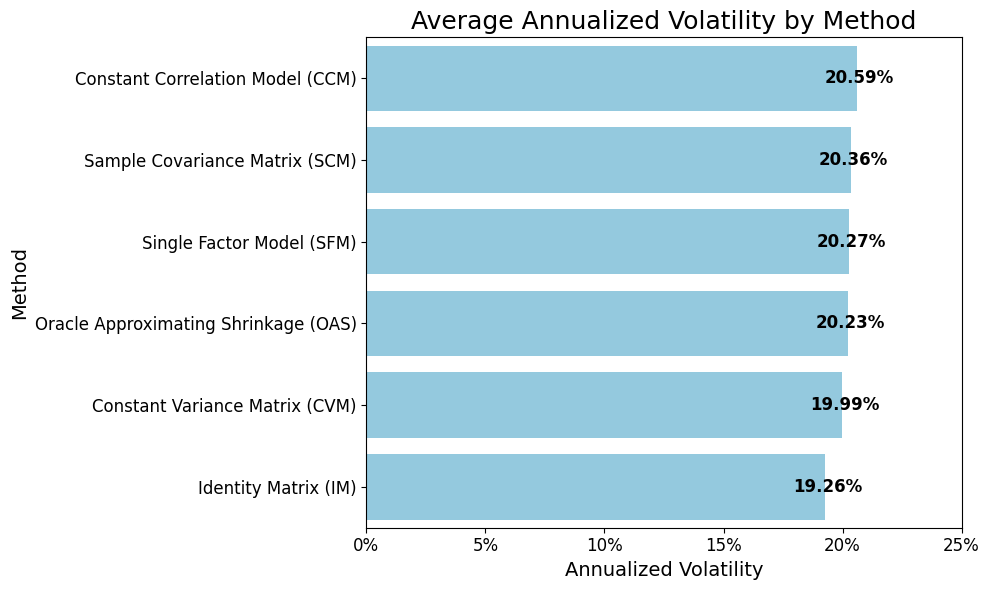

In [21]:

# Provided values
data = {
    'Method': [
        'Constant Correlation Model (CCM)',
        'Sample Covariance Matrix (SCM)',
        'Single Factor Model (SFM)',
        'Oracle Approximating Shrinkage (OAS)',
        'Constant Variance Matrix (CVM)',
        'Identity Matrix (IM)'
    ],
    'Annualized Volatility': [
        0.205924,
        0.203611,
        0.202716,
        0.202270,
        0.199884,
        0.192634
    ]
}

avg_volatility_df = pd.DataFrame(data)

# Sort the DataFrame by Annualized Volatility in descending order
avg_volatility_df = avg_volatility_df.sort_values('Annualized Volatility', ascending=False)

# Plot the average annualized volatility for each method
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x='Annualized Volatility', y='Method', data=avg_volatility_df, color='skyblue')

# Add labels and title with increased font size
plt.xlabel('Annualized Volatility', fontsize=14)
plt.ylabel('Method', fontsize=14)
plt.title('Average Annualized Volatility by Method', fontsize=18)

# Add the actual value on top of each bar with increased size and uniform positioning
for index, row in avg_volatility_df.iterrows():
    barplot.text(row['Annualized Volatility'] + 0.001, index, f'{row["Annualized Volatility"]:.2%}', 
                 ha='center', va='center', fontweight='bold', fontsize=12)

# Set x-axis ticks to 5%, 10%, ..., 25% with increased font size
plt.xticks(np.arange(0, 0.26, 0.05), [f'{int(x*100)}%' for x in np.arange(0, 0.26, 0.05)], fontsize=12)

# Increase the size of the tick labels on the y-axis
barplot.set_yticklabels(barplot.get_yticklabels(), fontsize=12)

# Adjust layout to make room for labels
plt.tight_layout()

# Display the plot
plt.show()

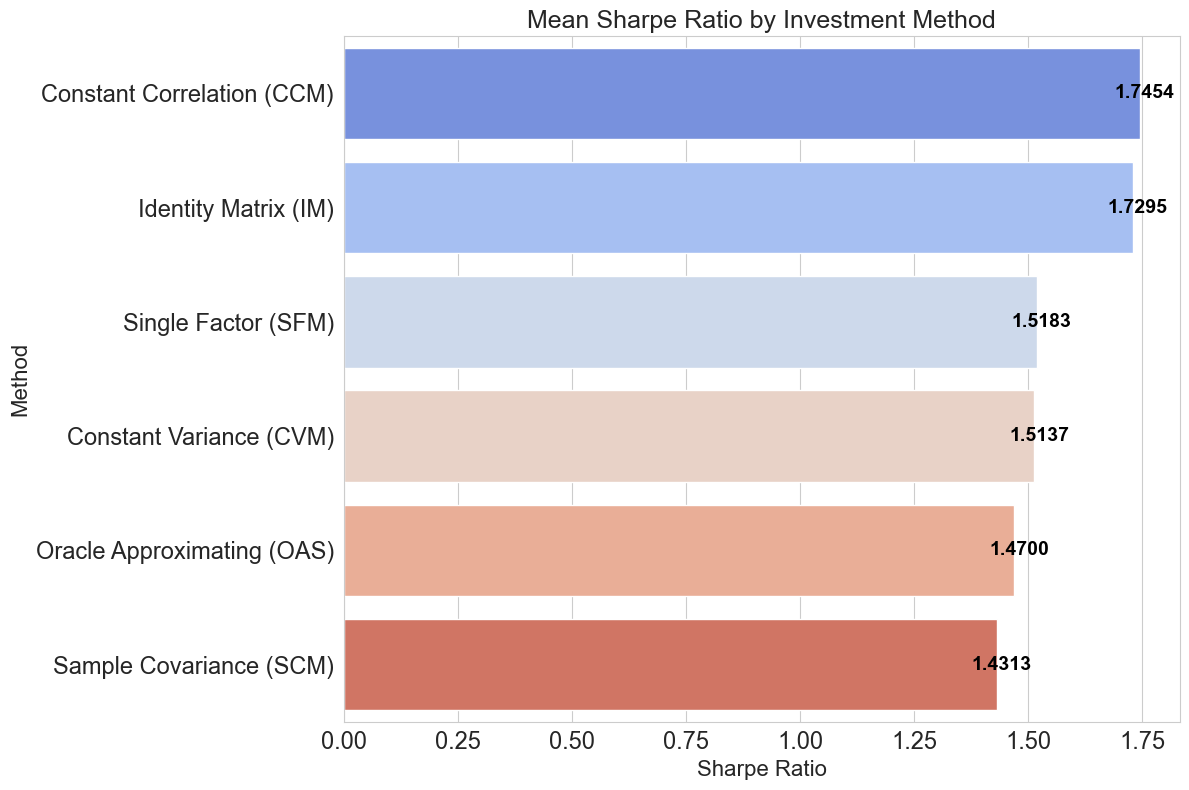

In [22]:
# Calculate the average Sharpe ratio for each method
mean_sharpe_ratios = annual_data.groupby('Method')['Sharpe Ratio'].mean().reset_index()

# Define a mapping from your method variable names to descriptive names
method_names = {
    'constant_correlation': 'Constant Correlation (CCM)',
    'constant_variance': 'Constant Variance (CVM)',
    'single_factor': 'Single Factor (SFM)',
    'oracle_approximation': 'Oracle Approximating (OAS)',
    'sample_cov': 'Sample Covariance (SCM)',
    'shrunk_covariance': 'Identity Matrix (IM)'
}

# Update your DataFrame to replace the method identifiers with descriptive names
mean_sharpe_ratios['Method'] = mean_sharpe_ratios['Method'].map(method_names)

# Sort the DataFrame by Sharpe Ratio in descending order
mean_sharpe_ratios = mean_sharpe_ratios.sort_values('Sharpe Ratio', ascending=False)

# Set the style of seaborn for more stylish plots
sns.set_style("whitegrid")

# Create a figure and axis object with matplotlib
plt.figure(figsize=(12, 8))
ax = plt.subplot(111)

# Create a bar chart using seaborn which automatically adds a grid
bars = sns.barplot(x='Sharpe Ratio', y='Method', data=mean_sharpe_ratios, palette='coolwarm', ax=ax)

# Add labels and title
ax.set_xlabel('Sharpe Ratio', fontsize=16)
ax.set_ylabel('Method', fontsize=16)
ax.set_title('Mean Sharpe Ratio by Investment Method', fontsize=18)

# Increase the size of the tick labels on both axes
ax.set_xticklabels(ax.get_xticklabels(), fontsize=17)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=17)

for bar in bars.patches:
    ax.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, 
            f'{bar.get_width():.4f}', ha='center', va='center', 
            fontweight='bold', color='black', fontsize=14) 

# Adjust the layout to make room for the labels
plt.tight_layout()

# Show the plot
plt.show()